In [1]:
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import ipywidgets as widgets
import seaborn as sns
import IPython.display as ipd


### The Next cell basically manages the dataset to have similar country names. Many Countries are not in the json file that we have. So we are getting rid of it. 

In [2]:
# Load the CSV file

pop_raw = pd.read_csv('./population-and-demography.csv')
male_pop_raw = pd.read_csv('./Male - population-and-demography.csv')
female_pop_raw = pd.read_csv('./female - population-and-demography.csv')
life_expec_raw = pd.read_csv('./life expectancy - population-and-demography.csv')
death_rate_raw = pd.read_csv('./death rate - population-and-demography.csv')
birth_rate_raw = pd.read_csv('./birth rate - population-and-demography.csv')
child_death_raw = pd.read_csv('./child mortality rate - population-and-demography.csv')

                   
# List of non-country entries created by chat GPT 
non_countries = [
    'Africa (UN)', 'Asia (UN)', 'Europe (UN)', 'High-income countries', 'Land-locked developing countries (LLDC)', 
    'Latin America and the Caribbean (UN)', 'Least developed countries', 'Less developed regions', 
    'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 
    'Low-income countries', 'Lower-middle-income countries', 'More developed regions', 'Northern America (UN)',
    'Oceania (UN)', 'Small island developing states (SIDS)', 'Upper-middle-income countries', 'World', 'Aruba', 'Barbados', 'Burundi', 'Saint Barthelemy', 'Bermuda', 'Brunei',
    'Bonaire Sint Eustatius and Saba', "Cote d'Ivoire", 'Curacao', 'Falkland Islands',
    'French Guiana', 'Guernsey', 'Guam', 'Jersey', 'Kiribati', 'Saint Martin (French part)',
    'Northern Mariana Islands', 'Nauru', 'Niue', 'Reunion', 'Rwanda',
    'Sint Maarten (Dutch part)', 'Tokelau', 'Turkey', 'Kosovo', 'Yemen' 
]

# Filter out the non-country entries
pop = pop_raw[~pop_raw['Country name'].isin(non_countries)]
male_pop = male_pop_raw[~male_pop_raw['Country name'].isin(non_countries)]
female_pop = female_pop_raw[~female_pop_raw['Country name'].isin(non_countries)]
life_expec_raw2 = life_expec_raw[~life_expec_raw['Country name'].isin(non_countries)]
death_rate_raw2 = death_rate_raw[~death_rate_raw['Country name'].isin(non_countries)]
birth_rate_raw2 = birth_rate_raw [~birth_rate_raw ['Country name'].isin(non_countries)]
child_death_raw2 = child_death_raw[~child_death_raw['Country name'].isin(non_countries)]

#Filter out 'Vatican' from some files
death_rate = death_rate_raw2[death_rate_raw2['Country name'] != 'Vatican']
birth_rate = birth_rate_raw2[birth_rate_raw2['Country name'] != 'Vatican']
child_death = child_death_raw2[child_death_raw2['Country name'] != 'Vatican']
life_expec = life_expec_raw2[life_expec_raw2['Country name'] != 'Vatican']


### In the next cell I only kept the column that I will use 

In [3]:
pop = pop[['Country name', 'Year', 'Population']]
male_pop = male_pop[['Country name', 'Year', 'Male population']]
female_pop = female_pop[['Country name', 'Year', 'Female population']]


### All the data we had didn't have any ISO3 code with them which we will use to make a link with our worl.json file. So we used chatGPT to create the ISO3 for every countyr. The prompt was "Here is the name of the countires. Now use your knowledge to give me the ISO3 and ISO2 for the countires and give me the list in a CSV file"

In [4]:
iso = pd.read_csv('./Country_with_ISO_Codes.csv')

### Creating a new dataset combining all the data

In [5]:
dataframes = {
    'pop': pop,
    'male_pop': male_pop,
    'female_pop': female_pop,
    'death_rate': death_rate,
    'birth_rate': birth_rate,
    'child_death': child_death
}


columns_to_take = [
    ['Country name', 'Year', 'Population'],
    ['Country name', 'Year', 'Male population'],
    ['Country name', 'Year', 'Female population'],
    ['Country name', 'Year', 'Death rate'],
    ['Country name', 'Year', 'Birth rate'],
    ['Country name', 'Year', 'Child mortality rate']
]

# Initialize an empty DataFrame
final_df = pd.DataFrame()

# Iterate over the datasets and columns
for dataset_name, columns in zip(dataframes.keys(), columns_to_take):
    df = dataframes[dataset_name][columns]
    if final_df.empty:
        final_df = df
    else:
        final_df = final_df.merge(df, on=['Country name', 'Year'], how='inner')


#Merging data with ISO        
final = final_df.merge(iso, on='Country name', how='left')

final.to_csv('./final.csv', index=False)

### Merging data for heatmap with GEO JSON

In [6]:
# Load the GeoJSON data
world_geo = gpd.read_file('./world.json')

# Filter the population data for the year 2021
final_2021 = final[final['Year'] == 2021]

# Merge the population data with geographical data using ISO3 codes
merged_data = world_geo.merge(final_2021, left_on='id', right_on='ISO3')

# Applying a logarithmic scale to the population data
merged_data['Log_Population'] = np.log1p(merged_data['Population'])

# Convert the merged GeoDataFrame to a GeoJSON format
geojson_data = json.loads(merged_data.to_json())


### Creating Heat map for different data

In [7]:
# Create a Population Choropleth map using Altair
choropleth_map_pop = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Log_Population:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Logarithmic Population',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Population:Q', title='Population')
    ]
).properties(
    title='Population',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)


# Create a birth rate Choropleth map using Altair
choropleth_map_birth = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Birth rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Birth rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Birth rate:Q', title='Birth rate')
    ]
).properties(
    title='Birth Rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Create a Mortality rate Choropleth map using Altair
choropleth_map_death = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Death rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Mortality rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Death rate:Q', title='Mortality Rate')
    ]
).properties(
    title='Mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Create a Child mortality rate Choropleth map using Altair
choropleth_map_child = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Child mortality rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Child mortality rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Child mortality rate:Q', title='Child Mortality Rate')
    ]
).properties(
    title='Child mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)


In [8]:
# # Filter the data for the year 2021
# final_2021 = final[final['Year'] == 2021]

# # Load your JSON file for geographical data
# json_file_path = './world.json'  # Replace with the path to your JSON file
# with open(json_file_path, 'r') as file:
#     world_json = json.load(file)


# # Preparing the GeoJSON data
# features = world_json['objects']['countries']['geometries']  # Replace 'your_object_name' with the actual name
# geojson_data = {"type": "FeatureCollection", "features": features}

# # Create a selection dropdown to choose the metric for the heatmap
# metrics = ['Population', 'Male population', 'Female population', 'Death rate', 'Birth rate', 'Child mortality rate']
# input_dropdown = alt.binding_select(options=metrics, name='Metric')
# selection = alt.selection_point(fields=['Metric'], bind=input_dropdown)

# # Prepare the GeoJSON for use in Altair
# geojson = alt.InlineData(values=geojson_data, format=alt.DataFormat(property='features', type='json'))

# # Base map layer
# base = alt.Chart(geojson).mark_geoshape(
#     fill='lightgray',
#     stroke='black'
# ).properties(
#     width=800,
#     height=400
# )

# # Heatmap layer
# heatmap = alt.Chart(geojson).mark_geoshape().encode(
#     color=alt.condition(selection,
#                         alt.Color('properties.value:Q', scale=alt.Scale(scheme='yellowgreenblue')),
#                         alt.value('lightgray'))
# ).transform_lookup(
#     lookup='id',
#     from_=alt.LookupData(final_2021, 'ISO3', metrics)
# ).transform_fold(
#     metrics, as_=['Metric', 'value']
# ).add_selection(
#     selection
# ).properties(
#     title='Interactive Heatmap for Demographic Data (2021)'
# )

# # Combine the layers
# final_map = base + heatmap
# final_map

### This cell is interactive where you can choose map to show it from the drop down

In [9]:
charts = {
    "Population": choropleth_map_pop,
    "Birth Rate": choropleth_map_birth,
    "Mortality Rate": choropleth_map_death,
    "Child Mortality Rate": choropleth_map_child
    # Add other charts here if needed
}

# Function to display the selected chart
def show_chart(chart_name):
    with chart_output:
        chart_output.clear_output(wait=True)
        display(charts[chart_name])

dropdown_output = widgets.Output()
chart_output = widgets.Output()

# Create a dropdown to select the chart
dropdown = widgets.Dropdown(options=charts.keys(), description='Select Chart:')


def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_chart(change['new'])

dropdown.observe(on_dropdown_change, names='value')


with dropdown_output:
    display(dropdown)

with chart_output:
    display(charts[list(charts.keys())[0]])

# Display the output widgets
display(dropdown_output)
display(chart_output)

Output()

Output()

### Now we will take a further look into some of the most or least populus country in the world

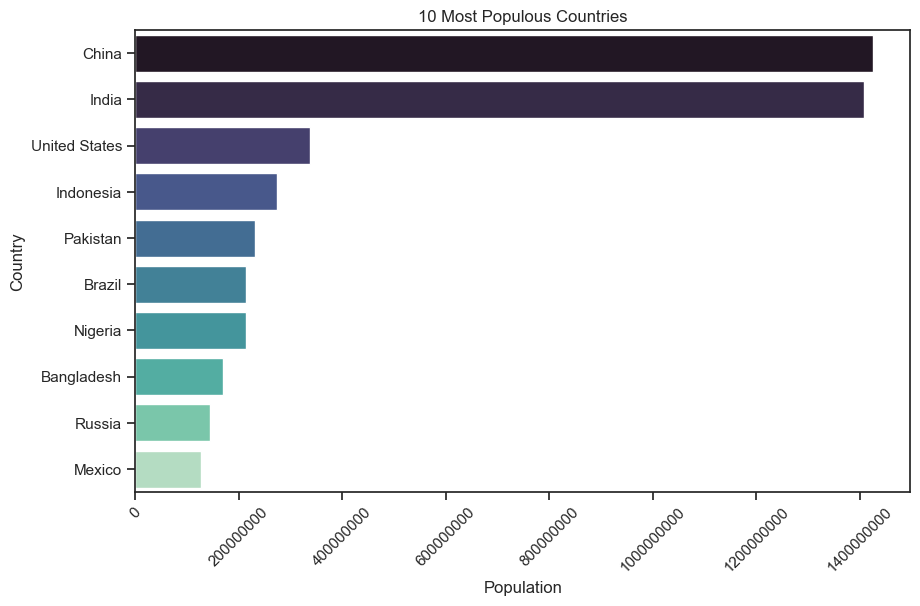

In [20]:
from mpl_toolkits.mplot3d import Axes3D
most_populous= final[final['Year'] == 2021].nlargest(10, 'Population')

sns.set_theme(style="ticks")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Population', y='Country name', data=most_populous, palette="mako")

plt.title('10 Most Populous Countries')
plt.xlabel('Population')
plt.ylabel('Country')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')  # Change the x-axis label format to plain

plt.show()

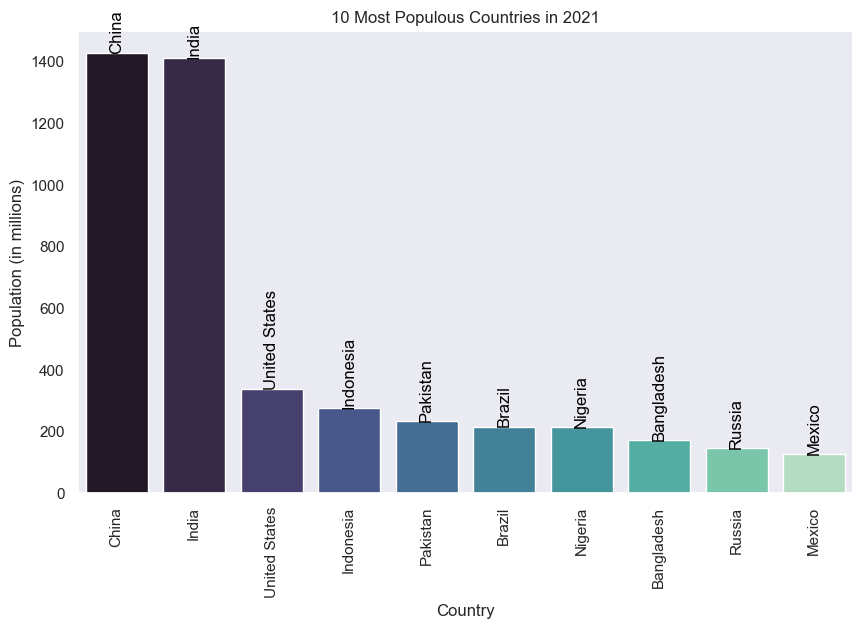

In [24]:
# Adjust population to be in millions for display
most_populous['Population in Millions'] = most_populous['Population'] / 1e6

# Create a vertical bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(y='Population in Millions', x='Country name', data=most_populous, palette="mako", orient='v')

# Set the title and labels
plt.title('10 Most Populous Countries in 2021')
plt.ylabel('Population (in millions)')
plt.xlabel('Country')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add the country name and population number on top of each bar
for bar, label in zip(barplot.patches, most_populous['Country name']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, 
             ha='center', va='bottom', rotation=90, color='black')

# Show the plot
plt.show()

